In [53]:
%matplotlib inline
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.utils.nddata import NDDataArray, BinnedDataAxis


In [74]:
offset_max = 5*u.deg
theta = np.linspace(0.,offset_max.value,101)*u.deg
phi = np.linspace(0,np.pi,11)*u.rad
energy = np.logspace(-1.,1.,31)*u.TeV

theta_lo = theta[:-1]
theta_hi = theta[1:]
theta = 0.5*(theta_lo + theta_hi)

phi_lo = phi[:-1]
phi_hi = phi[1:]
phi = 0.5*(phi_lo + phi_hi)

energy_lo = energy[:-1]
energy_hi = energy[1:]
energy = 0.5*(energy_lo + energy_hi)

scale = 2
scale2 = 3
Eref = 1

T,P,E = np.meshgrid(theta.value,phi.value,energy.value)
print T.shape

(10, 100, 30)


Most IRF are stored as a function of the FoV polar coordinates ``fov_theta`` and ``fov_phi``.

Here we define a typical effective area with some phi dependency. 

In [75]:
axis_theta = BinnedDataAxis(theta_lo, theta_hi,name='fov_theta')
axis_phi = BinnedDataAxis(phi_lo, phi_hi,name='fov_phi')
axis_energy_true = BinnedDataAxis(energy_lo,energy_hi,name='energy_true'
                                  ,interpolation_mode='log')

data = np.exp(-0.5*(T/scale)**2)*(1+0.1*np.cos(P))*(E/Eref)**-2

aeff = NDDataArray([axis_phi,axis_theta,axis_energy_true], data)


We have also IRFs that use lon and lat FoV coordinates (incorrectly written det_x and det_y in some cases). This is usually the case for the background. We define it in ``fov_lon`` and ``fov_lat`` coordinates.

In [76]:
fov_x = np.linspace(-offset_max,offset_max,101)*u.deg

fov_x_lo = fov_x[:-1]
fov_x_hi = fov_x[1:]
fov_x = 0.5*(fov_x_lo + fov_x_hi)

X,Y,E = np.meshgrid(fov_x.value,fov_x.value,energy.value)


axis_x = BinnedDataAxis(fov_x_lo, fov_x_hi,name='fov_lon')
axis_y = BinnedDataAxis(fov_x_lo, fov_x_hi,name='fov_lat')
axis_energy_reco = BinnedDataAxis(energy_lo,energy_hi,name='energy_reco',
                                  interpolation_mode='log')

data = np.exp(-0.5*(X**2+Y**2)/scale2**2)*(E/Eref)**-2.7

bkg = NDDataArray([axis_x,axis_y,axis_energy_reco], data)


For the moment the NDDataArray.evaluate method assumes 1D inputs and applies broadcasting.

N-dim arrays are flattened before broadcasting yielding huge output.

In [79]:
bkg_eval = bkg.evaluate(fov_lon=fov_x[::5],fov_lat=fov_x[::3],
                        energy_reco = np.logspace(-0.5,1.,10)*u.TeV)
print bkg_eval.shape

(20, 34, 10)


This logic does not apply for the case of ``fov_theta`` and ``fov_phi``.

A typical use case consists in producing an exposure and a background map for a given observation. 

We start with a ``gammapy.maps.WcsNDMAp`` and we need to project all its coordinates into the FoV frame, either lon/lat or polar angles.

In [57]:
from gammapy.maps import WcsNDMap, WcsGeom, MapAxis
energy = np.logspace(-1.,1.,31)*u.TeV
mapaxis_energy_reco = MapAxis(energy.value, interp='log', node_type='edge',
                           name='energy_reco', unit = energy.unit)
pos = SkyCoord(0.0, 0.0, frame='galactic',unit='deg')

geom = {'binsz':0.02, 'coordsys':'GAL', 'width' : 15*u.deg,
            'skydir' : pos, 'axes' : [mapaxis_energy_reco]}

wcsgeom = WcsGeom.create(**geom)
mask = WcsNDMap(wcsgeom)

The initial step for processing any observation (or IRF time interval) is to convert the spatial coordinates of the target map in the fov frame.

In [68]:
new_geom = wcsgeom.to_image()

tmp_coords = new_geom.get_coords()
glon = tmp_coords[0]
glat = tmp_coords[1]

## The first two coordinates are spatial
skycoords = SkyCoord(glon, glat, frame='galactic', unit='deg')

# The FoV frame. We use random rotation of 20 deg
# and pointing position 
pointing = SkyCoord(2.5,-1.5,frame='galactic',unit="deg")
fovframe = pointing.skyoffset_frame(rotation=20*u.deg)

fov_coords = skycoords.transform_to(fovframe)

fov_lon, fov_lat= fov_coords.lon, fov_coords.lat

fov_theta = skycoords.separation(pointing)
fov_phi = np.arccos(fov_lon/fov_theta).to('deg')*np.sign(fov_lat)

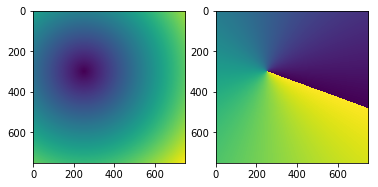

In [69]:
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(121)
plt.imshow(fov_theta)
plt.subplot(122)
plt.imshow(fov_phi)


In practice we want to be able to call any IRF with the fov_coords without knowing what is the exact axis definition, e.g.
``aeff.evaluate(fov_coords,energy_true=energy)``
This should return an array of shape ``(fov_coords.shape, fov_coords.shape, energy.shape)``.

The conversion between ``(fov_lon,fov_lat)`` and ``(fov_theta,fov_phi)`` should be done in the evaluate method.

In [80]:
mask.geom.get_coords()
mask.get_by_coords

<bound method WcsGeom.get_coords of <gammapy.maps.wcs.WcsGeom object at 0x117933410>>